In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import imp 
import pickle
from IPython.display import clear_output, display
import scipy
from PIL import Image
import itertools

from context import rf_pool
from rf_pool.utils.functions import gabor_filter
from rf_pool.data.transforms import RandomAffine
from rf_pool.utils import visualize

In [2]:
from dataset_func import CrowdedGratings
from helper_func import load_matlab_struct, filter_by_index
from likelihood_models import RFWeightedSub, RFWeightedMult

## Image-computable models

In [3]:
def train_model(model, optimizer, data_loader, n_epochs=1, subID=None): 
    # training loop
    tracking = []
    for epoch in range(n_epochs):
        running_likelihood = 0 
        for i, (X,resp) in enumerate(data_loader):
            # compute gradient
            optimizer.zero_grad()
            log_likelihood = model(X,resp)
            log_likelihood.backward()
            optimizer.step()
            running_likelihood += -log_likelihood.item()
            
        tracking.append(running_likelihood/ ((X.shape[0]*i)+1))   
        clear_output(wait=True)
        plt.plot(tracking)
        plt.xlabel("epoch")
        plt.ylabel("log likelihood")
        plt.xlim([0,n_epochs])
        display(subID)
        display(plt.show())

    return model

**Parameters**

In [4]:
# dataset parameters
diameter = 15
input_shape = (120,120)
spacing=48
n_flankers = 9
n_cycles = 5.
contrast = 1.
background_size = input_shape[0];
background_value = 127
axis = 3*np.pi/2
transform = transforms.Compose([transforms.ToTensor(),
                                RandomAffine(translate=(.05,.05), degrees=0.)])

# rf pooling layer parameters 
RF_rate = torch.tensor(0.2)
pool_shape = torch.Size((49,49))
eccentricity = 3
offset = [0., -eccentricity*diameter]
attention_mu = torch.tensor([np.array(pool_shape) // 2], dtype=torch.float)

# cortical mu and sigma
cortical_mu=None
cortical_sigma=None

# conv filters
n_orientations=8
weight_dict = pickle.load(open('orientation_classifier_weights.pkl', 'rb'))
orientations = np.linspace(0, np.pi-(10*np.pi/180), n_orientations)

# kernel_size = 10
# n_orientations = 8
# orientations = (180/n_orientations) * np.arange(n_orientations)
# gabors = [gabor_filter(theta=theta, sigma=3, wavelength=10, filter_shape=(10,10), gamma=1, psi=3*np.pi/2.)
#           for theta in orientations]
# gabors = torch.unsqueeze(torch.stack(gabors), 1)
# gabor_weight_dict= {"0.hidden.weight":gabors,
#                     "0.hidden.bias": torch.zeros(int(n_orientations))}

# fig,ax = plt.subplots(1,gabors.shape[0],figsize=(10,4))
# for i in range(gabors.shape[0]):
#     ax[i].imshow(gabors[i,0],"gray")
    

**Base RF Net**

In [5]:
def get_model(attention_sigma):
    rf_layer = rf_pool.pool.RF_Foveated(img_shape=pool_shape, scale=RF_rate, n_rings=30, std=1,
                                        offset=offset, pool_fn ='max_pool', ref_axis=0,
                                        attention_mu=attention_mu, attention_sigma=attention_sigma, 
                                        vectorize=True)
    # initialize the rf pass of the model
    model = rf_pool.models.Model()
    model.add_module('0', rf_pool.modules.FeedForward(
                          hidden=torch.nn.Conv2d(1,32,5),
                          activation=torch.nn.ReLU(),
                          pool = torch.nn.MaxPool2d(2))
                    )
    model.add_module('1', rf_pool.modules.FeedForward(
                          hidden=torch.nn.Conv2d(32,8,10),
                          pool=rf_layer)
                    )
    
    model.load_state_dict(weight_dict, False)
    
    return model

**Pick Task**

In [41]:
task_type = '2/' # target task = 1/; ensemble task = 2/

subject_id = ["sub001", "sub002", "sub003", "sub004", "sub005", "sub006", "sub007", "sub008", "sub009",
              "sub010", "sub012", "sub013", "sub014", "sub015", "sub017", "sub018", "sub020", "sub021",
              "sub022"]

validity_cond = ["valid", "invalid"]; validity = [0, 1]
cue_cond = ["small", "big"] #[np.min(data["cue_size"]), np.max(data["cue_size"])]

**Pick Model**

In [42]:
filename = 'rf_model_fits/ensemble_task_sub_s_sigma.pkl'
batch_size = 10
Model = RFWeightedSub
n_epochs = 50
lr = 1e-1
lr_att_sigma = 1e-1


def init_model_optimizer(Model):
    attention_sigma = torch.tensor([.5*diameter*3], requires_grad=True)
    rf_model = get_model(attention_sigma)
    o = torch.tensor(orientations, dtype=torch.float32).unsqueeze(-1)
    
    # initialize parameters
    p = torch.tensor([.5], requires_grad=True)
    s = torch.ones(1,14, requires_grad=True)
    scale = torch.tensor([np.pi/4], requires_grad=True)
    
    model = Model(o, rf_model, p, s, scale, k=.5)
    
    # Don't update gabor weights
    for name, param in model.named_parameters():
        if 'hidden' in name:
            param.requires_grad = False

    optimizer = torch.optim.SGD([{'params':[model.p], 'lr':lr},
                                 {'params':[model.s], 'lr':lr},
                                 {'params':[model.scale], 'lr':lr},
                                 {"params":model.parameters(), "lr":lr_att_sigma}])
    
    return model, optimizer


**Run Experiments**

In [43]:
key_txt = '{cue_size}_{validity}'
trained_data = {};
for cue, val in list(itertools.product(cue_cond, validity_cond)):
    cond_key = key_txt.format(cue_size = cue, validity = val)
    trained_data.update({cond_key: {'params':[], 'likelihood': []}})
    
cond_keys = list(trained_data.keys())

'sub022_big_invalid'

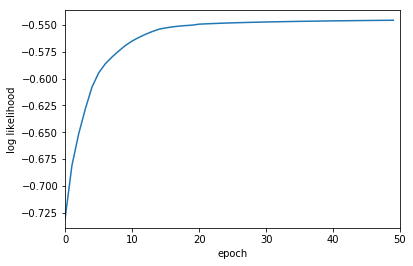

None

In [44]:
not_nan = lambda x,_: ~np.isnan(x,_)

for i, subj in enumerate(subject_id):
    struct = scipy.io.loadmat('ensemble_cueing_data/' + task_type + subj + '.mat')
    data = load_matlab_struct(struct)
    cue_sizes = [np.min(data["cue_size"]), np.max(data["cue_size"])]
        
    for key, (cue, val) in zip(cond_keys, list(itertools.product(cue_sizes, validity))):
        # filter for cue/validity
        idx = filter_by_index(data,
                              ["valid", "cue_size", "response"],
                              [np.equal, np.equal, not_nan],
                              [val, cue, None])
        
        # make the data loader
        root_data = (data['response'][idx]*np.pi/180, data["ensemble_val"][:,idx[0]]*np.pi/180)

        crowdset = CrowdedGratings(root_data, diameter=diameter,
                                  n_cycles=n_cycles, contrast=contrast,
                                  transform=transforms.ToTensor(), background_size=background_size,
                                  axis=axis, spacing=spacing, background_value=background_value)

        crowdloader = torch.utils.data.DataLoader(crowdset, batch_size=batch_size,
                                                 shuffle=False, num_workers=0)
        
        
        
        # fit the model
        model, optim = init_model_optimizer(Model)
        train_model(model, optim, crowdloader, n_epochs=n_epochs, subID=subj+'_'+key)
        
        # append the data
        with torch.no_grad():
            # params
            params = [param['params'][-1].detach().numpy() for param in optim.param_groups
                 if param['params'][-1].requires_grad==True]
            
            trained_data[key]['params'].append(params)
            
            # likelihoods
            total_likelihood = []
            for _, (X,resp) in enumerate(crowdloader):
                model.forward(X,resp)
                total_likelihood += list(model.total_likelihood.detach().numpy())
            
            trained_data[key]['likelihood'].append(total_likelihood)
        
    with open(filename, 'wb') as f:
        pickle.dump(trained_data, f)

## Plots

**Likelihood Estimates**

In [39]:
data = pickle.load(open('rf_model_fits/target_task_sub_sigma.pkl', 'rb'))
for a in data['small_valid']['likelihood']:
    print(a)

[array([0.5177062 , 0.44199467, 0.82373804, 0.79740906, 0.6083358 ,
       0.69624066, 0.5589738 , 0.4441533 , 0.7236132 , 0.47451508],
      dtype=float32), array([0.7856606 , 0.5717622 , 0.48224062, 0.40535063, 0.5892471 ,
       0.49576876, 0.5022526 , 0.5836545 , 0.39538845, 0.41528326],
      dtype=float32), array([0.5257896 , 0.5342591 , 0.4267584 , 0.83158857, 0.4514136 ,
       0.6905951 , 0.6985475 , 0.6962501 , 0.60900795, 0.41212216],
      dtype=float32), array([0.57562697, 0.63693345, 0.415681  , 0.44206434, 0.80048275,
       0.43624008, 0.40598756, 0.5688583 , 0.6538453 , 0.4821115 ],
      dtype=float32), array([0.73399246, 0.539458  , 0.3844996 , 0.46521232, 0.4612215 ,
       0.4367299 , 0.42713803, 0.5499858 , 0.6615356 , 0.46264875],
      dtype=float32), array([0.5384215 , 0.6573411 , 0.687653  , 0.7679026 , 0.47159082,
       0.4503836 , 0.41508567, 0.41200238, 0.712911  , 0.37484497],
      dtype=float32), array([0.5430245 , 0.63369334, 0.34014803, 0.26556188, 0.

(0, 0.35)

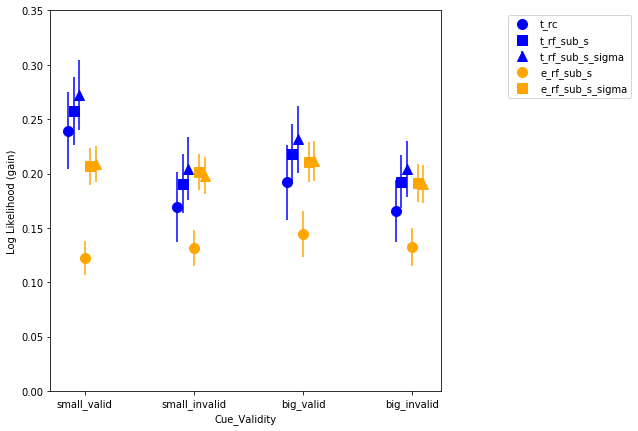

In [49]:
filenames = ['mean_model_fits/target_task_rc.pkl',
             'rf_model_fits/target_task_sub_s.pkl',
             'rf_model_fits/target_task_sub_s_sigma.pkl',
             'mean_model_fits/ensemble_task_rc.pkl',
             'rf_model_fits/ensemble_task_sub_s.pkl',
             'rf_model_fits/ensemble_task_sub_s_sigma.pkl']

names = ['t_rc','t_rf_sub_s','t_rf_sub_s_sigma', 'e_rf_sub_s', 'e_rf_sub_s_sigma']
colors = ['blue','blue','blue', 'orange', 'orange', 'orange']
markers = ['o','s','^','o','s','^']

step= .05
n_steps = len(filenames)/2 - 1

fig = plt.figure(figsize=(7,7))
for i, file in enumerate(filenames):
    data = pickle.load(open(file, 'rb'))
    means = []
    sems = []
    for key in cond_keys:  
        if i == 0 or i ==3:
            l = [np.mean(np.log(np.array(a)*.99+.005)-np.log(.5)) for a in data[key]['likelihood']]
        else:
            l = [np.mean(np.log(np.concatenate(a)*.99+.005)-np.log(.5))
                 for a in data[key]['likelihood']]
        means.append(np.mean(l))
        sems.append(np.std(l)/np.sqrt(len(l)))
    if i <= n_steps:
        plt.errorbar(np.arange(4)-step*((n_steps+1)-(i%(n_steps+1))),means,sems, color=colors[i],
                     marker=markers[i],markersize=10, linestyle='none')
    else:
        plt.errorbar(np.arange(4)+ step*(i%(n_steps+1)),means,sems, color=colors[i],
                     marker=markers[i],markersize=10, linestyle='none')
        
plt.xticks(range(4), labels=cond_keys)
plt.ylabel('Log Likelihood (gain)')
plt.xlabel('Cue_Validity')
plt.legend(names,bbox_to_anchor=(1.5, 1))
plt.ylim(0,.35)

**Spatial Weight Heat Map**

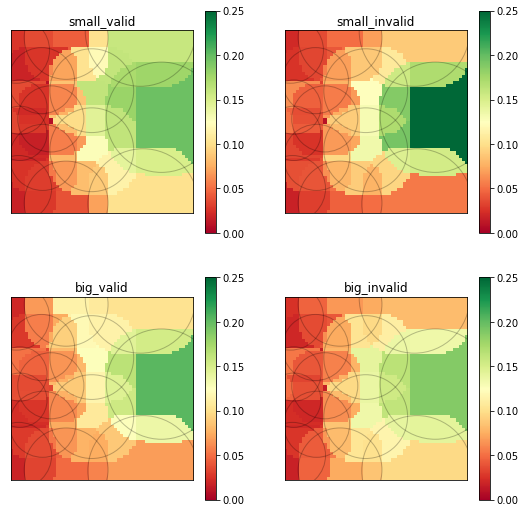

In [56]:
filenames = ['rf_model_fits/ensemble_task_sub_s.pkl'] 
#              'rf_model_fits/ensemble_task_sub.pkl']


fig, ax= plt.subplots(figsize=(9, 9), nrows=2, ncols=2)

key_txt = '{cue_size}_{validity}'
trial_type = ['valid', 'invalid']
colors = ['blue', 'red']
cue_type = ['small','big']
task_type = ["target task", "ensemble task"]

for k, file in enumerate(filenames):
    data = pickle.load(open(file, 'rb'))
    for i, t in enumerate(trial_type):
        for j,c in enumerate(cue_type):
            key = key_txt.format(cue_size=c,validity=t)
            s = np.squeeze(np.array([param[1] for param in data[key]['params']]))
            s = s / np.sum(s,axis=1).reshape(19,1)
            d = np.mean(s,axis=0)
            visualize.heatmap(model.model, '1', scores=torch.tensor(d),
                              colorbar=True, cmap='RdYlGn', ax=ax[j,i], show=False,
                              vmin=0,vmax=.25 )
            ax[j,i].set_title(key)
            
plt.show()          

**Attention Sigma**

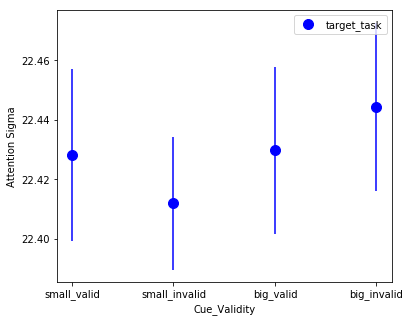

In [53]:
filenames = ['rf_model_fits/target_task_sub_sigma.pkl']

names = ['target_task']
colors = ['blue']
markers = ['o']

fig = plt.figure(figsize=(6,5))
for i, file in enumerate(filenames):
    means = []
    sems = []
    for key in cond_keys:
        data = pickle.load(open(file, 'rb'))
        sigma = np.array([param[-1] for param in data[key]['params']])
        means.append(np.mean(sigma))
        sems.append(np.std(sigma)/np.sqrt(len(sigma)))
    plt.errorbar(np.arange(4),means,sems, color=colors[i],marker=markers[i],markersize=10, linestyle='none')
plt.xticks(range(4), labels=cond_keys)
plt.ylabel('Attention Sigma')
plt.xlabel('Cue_Validity')
plt.legend(names)